# Digit data classification
숫자 데이터의 분류를 위한 코드로 main.py와 같은 기능을 합니다.

## 필요 SW
먼저 anaconda를 이용하여 python 설치가 필요합니다.  
아나콘다 링크: https://www.anaconda.com/products/individual  
그래픽 카드가 구비되어 있다면, 그래픽 카드에 맞는 CUDA 라이브러리의 설치가 필요합니다. (그래픽 카드별 지원하는 CUDA 버전이 다를 수 있음으로 확인이 필요합니다.)  
CUDA 설치 링크: https://developer.nvidia.com/cuda-10.1-download-archive-update2  
anaconda를 설치 완료했다면 현재 디렉토리에서 아래의 명령어를 통해 필요 패키지의 설치를 할 수 있습니다.
이후 본 프로젝트에서 사용할 패키지를 import 합니다.

In [ ]:
! pip3 install -r requirements.txt

In [32]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
import cv2
import models # models 폴더 내의 코드를 import 

from PIL import Image

### Data Loader
학습을 위해서는 먼저 data loader를 구성해주어야 합니다. data loader의 구현을 위해서 pytorch에서 제공되는 DataLoader를 사용합니다. DataLoader의 사용을 위해서는 아래의 DigitData와 같은 __getitem__, __len__ 모듈이 구현된 객체가 필요합니다. 또한 여러 data instance를 함께 학습에 사용하기 위해서는 이미지의 크기 조정이 필요합니다. 본 프로젝트에서는 추가적인 data augmentation 방법 없이 normalization을 사용하였습니다. 

In [35]:
class DigitData:
    def __init__(self, path, size=64, split='train'):
        self.path = path
        self.size = (size, size)
        
        # training set과 validation set 구분
        if split == 'train':
            self.image_files = open(os.path.join(path, 'train_data.txt'), 'r').read().splitlines()
      #  elif split == 'test':
      #      self.image_files = open(os.path.join(path, 'test_'))
        else:
            #self.image_files = open(os.path.join(path, 'test_data.txt'), 'r').read().splitlines()
            self.image_files = open(os.path.join(path, 'valid_data.txt'), 'r').read().splitlines()
            
        
        # 전체 데이터셋의 RGB 평균과 표준편차
        mean = [0.80048384, 0.44734452, 0.50106468]
        std = [0.22327253, 0.29523788, 0.24583565]
        self.transform = transforms.Compose([transforms.Resize(self.size), transforms.ToTensor(),
                                             transforms.Normalize(mean=mean, std=std)])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        path = os.path.join(self.path, self.image_files[idx])
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        target = int(self.image_files[idx].split('/')[0])
        return img, target

path = r'/home/ljh/Desktop/OCR_seven_ocr/dataset/digit_data' # digit_data가 있는 디렉토리
size = 64 # 이미지의 조정된 크기
batch_size = 128 # 한 번의 iteration에 사용할 instance의 수

train_data = DigitData(path, size, 'train')
valid_data = DigitData(path, size, 'valid')
test_data = DigitData(path, size, 'test')

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(train_loader)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [36]:
# 데이터의 수
print('# instances of train: {}'.
      format(len(train_data)))
print('# instances of validation: {}'.format(len(valid_data)))

# instances of train: 21789
# instances of validation: 5448


In [3]:
def transform_image(path):
    mean = [0.80048384, 0.44734452, 0.50106468]
    std = [0.22327253, 0.29523788, 0.24583565]
    my_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(),
                                             transforms.Normalize(mean=mean, std=std)])
    image = Image.open(path).convert('RGB')
    return my_transform(image).unsqueeze(0)

In [27]:
test_d = transform_image("101.png")
print(test_d.shape)

torch.Size([1, 3, 64, 64])


In [28]:
number = predict_model(new_model, test_d)
int(number)

1

### Visualization
사용할 data instance의 예시

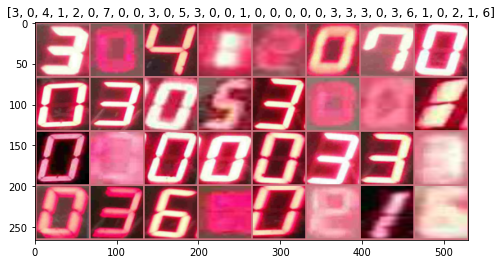

In [37]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.80048384, 0.44734452, 0.50106468])
    std = np.array([0.22327253, 0.29523788, 0.24583565])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs[:32])

imshow(out, title=[i.item() for i in classes[:32]])

### Training setting
학습을 시작하기 전에 직접 정해주어야 하는 요소가 있으며, 정해진 설정에 따라 성능이 차이가 날 수 있습니다. 결정해야 하는 부분은 전체 training data를 몇 번 반복하여 학습에 사용할 지를 결정하는 epoch, gradient를 사용하여 모델 파라미터를 어떻게 업데이트 할 지 결정하는 optimizer, gradient의 반영 정도를 의미하는 learning rate, learning rate 조정을 위한 스케쥴, weight decay의 정도 그리고 네트워크의 구조가 있습니다.

In [38]:
model = 'resnet20' # resnet 구조 사용 가능, resnet8, resnet14, ... or resnet18, resnet34, resnet50 ...
optimizer = 'adam' # sgd or adam
scheduler = 'cosine' # cosine, poly, exponetial
learning_rate = 0.005 # learning rate
weight_decay = 0.0005 # l2 regularization weight
epochs = 10 # dataset 전체를 학습에 사용하는 횟수

model = models.__dict__[model](num_classes=10)
criterion = nn.CrossEntropyLoss() # loss 설정

if optimizer == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
elif optimizer == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
if scheduler == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
elif scheduler == 'poly':
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda x: (learning_rate * (1.0 - x / epochs) ** 0.9))
elif scheduler == 'exponential':
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

is_cuda = torch.cuda.is_available() # gpu 환경이 구축된 경우 gpu를 사용하여 학습 진행
if is_cuda:
    model.cuda()

In [39]:
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [40]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([16, 3, 3, 3])
bn1.weight 	 torch.Size([16])
bn1.bias 	 torch.Size([16])
bn1.running_mean 	 torch.Size([16])
bn1.running_var 	 torch.Size([16])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([16, 16, 3, 3])
layer1.0.bn1.weight 	 torch.Size([16])
layer1.0.bn1.bias 	 torch.Size([16])
layer1.0.bn1.running_mean 	 torch.Size([16])
layer1.0.bn1.running_var 	 torch.Size([16])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([16, 16, 3, 3])
layer1.0.bn2.weight 	 torch.Size([16])
layer1.0.bn2.bias 	 torch.Size([16])
layer1.0.bn2.running_mean 	 torch.Size([16])
layer1.0.bn2.running_var 	 torch.Size([16])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([16, 16, 3, 3])
layer1.1.bn1.weight 	 torch.Size([16])
layer1.1.bn1.bias 	 torch.Size([16])
layer1.1.bn1.running_mean 	 torch.Size([16])
layer1.1.bn1.running_var 	 torch.Size([16])
layer1.1.bn1.num_batches_tracked 	 torch.

### Train
학습과 테스트를 위한 함수를 구현합니다. 그 후 epoch 수에 따라 학습을 진행합니다.

In [41]:
class AvgMeter(object):
    # 성능 측정을 위한 객체
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def cal_acc(outputs, targets):
    # 정답률 확인을 위함
    _, pred = torch.max(outputs.data, 1)
    correct = pred.eq(targets).sum().item()
    acc = correct / targets.size(0)
    return acc

def train(model, data_loader, criterion, optimizer, cuda):
    '''
    모델의 학습을 위한 함수
    model: 학습에 사용되는 뉴럴 네트워크 모델
    data_loader: training data를 불러오는 객체
    criterion: loss function으로 cross entropy 사용
    optimizer: loss function에 따라 model의 parameter를 업데이트
    cuda: GPU 사용 여부
    '''
    model.train() # model을 training setting으로 교체

    # loss, accuracy 기록 (AvgMeter class 참고)
    train_loss = AvgMeter()
    train_acc = AvgMeter()
    for imgs, targets in data_loader:
        if cuda: # GPU를 사용하는 경우 data_loader의 출력을 CPU에서 GPU로 옮겨줌
            imgs, targets = imgs.cuda(), targets.cuda()
        outputs = model(imgs) # model 예측
        loss = criterion(outputs, targets) # loss 계산

        # model parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss, accuracy 기록
        train_loss.update(loss.item(), targets.size(0))
        train_acc.update(cal_acc(outputs, targets), targets.size(0))

    return train_loss.avg, train_acc.avg

def valid(model, data_loader, cuda):
    '''
    모델의 평가를 위한 함수
    model: 평가에 사용되는 뉴럴 네트워크 모델
    cuda: GPU 사용 여부
    '''
    model.eval() # model을 validation을 위한 상태로 변경

    valid_acc = AvgMeter() # accuracy 기록 (AvgMeter class 참고)
    predicted = 0

    for imgs, targets in data_loader:
        if cuda: # GPU를 사용하는 경우 data_loader의 출력을 CPU에서 GPU로 옮겨줌
            imgs, targets = imgs.cuda(), targets.cuda()
        with torch.no_grad(): # validation 시에 gradient 계산 불필요
            outputs = model(imgs) # model 예측
            _, predicted = torch.max(outputs.data, 1)

            
        valid_acc.update(cal_acc(outputs, targets), targets.size(0)) # accuracy 기록
        

    return valid_acc.avg, predicted


def predict_model(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
    return predicted
    

In [43]:
# 학습 진행
train_loss_list = []
train_acc_list = []
valid_acc_list = []
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, is_cuda)
    scheduler.step()
    valid_acc = valid(model, valid_loader, is_cuda)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)
    print('Epoch: {0:>3d}| Train loss: {1:0.4f}| Train Acc: {2:0.4f}| Valid Acc: {3:0.4f}'.format(epoch + 1, train_loss, train_acc, valid_acc))

TypeError: unsupported format string passed to tuple.__format__

### 모델 저장

In [15]:
torch.save(model.state_dict() , './model_state_dict.pt')

In [49]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([16, 3, 3, 3])
bn1.weight 	 torch.Size([16])
bn1.bias 	 torch.Size([16])
bn1.running_mean 	 torch.Size([16])
bn1.running_var 	 torch.Size([16])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([16, 16, 3, 3])
layer1.0.bn1.weight 	 torch.Size([16])
layer1.0.bn1.bias 	 torch.Size([16])
layer1.0.bn1.running_mean 	 torch.Size([16])
layer1.0.bn1.running_var 	 torch.Size([16])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([16, 16, 3, 3])
layer1.0.bn2.weight 	 torch.Size([16])
layer1.0.bn2.bias 	 torch.Size([16])
layer1.0.bn2.running_mean 	 torch.Size([16])
layer1.0.bn2.running_var 	 torch.Size([16])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([16, 16, 3, 3])
layer1.1.bn1.weight 	 torch.Size([16])
layer1.1.bn1.bias 	 torch.Size([16])
layer1.1.bn1.running_mean 	 torch.Size([16])
layer1.1.bn1.running_var 	 torch.Size([16])
layer1.1.bn1.num_batches_tracked 	 torch.

### Validation
검수를 위하여 validation set 내의 data에 대해 어떤 이미지의 분류를 잘못했는지 보여줍니다.

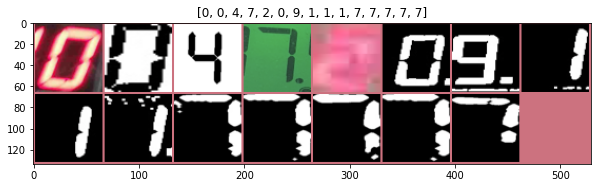

In [10]:
error_imgs = []
error_classes = []

for imgs, targets in valid_loader:
    if is_cuda:
        imgs, targets = imgs.cuda(), targets.cuda()
    with torch.no_grad():
        _, pred = torch.max(model(imgs), 1)
        
    for idx, (p,t) in enumerate(zip(pred, targets)):
        if not p==t:
            error_imgs.append(imgs[idx])
            error_classes.append(t)
            
out = torchvision.utils.make_grid(torch.stack(error_imgs, 0))
plt.figure(figsize = (10, 6))

imshow(out.cpu(), title = [i.item() for i in error_classes])

NameError: name 'train_loss_list' is not defined

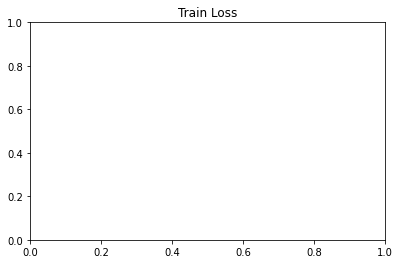

In [11]:
plt.rcParams["figure.figsize"] = (14,4)
ax1 = plt.subplot(121)
ax1.set_title('Train Loss')
ax1.plot(train_loss_list)
ax1.set_xlabel('Epoch')

ax2 = plt.subplot(122)
ax2.set_ylim([0.7,1])
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')

ax2.plot(valid_acc_list, label='Validation accuracy')
ax2.plot(train_acc_list, label='Training accuracy')
plt.legend()
plt.show()

In [15]:
new_model = 'resnet20' # resnet 구조 사용 가능, resnet8, resnet14, ... or resnet18, resnet34, resnet50 ...

new_model = models.__dict__[new_model](num_classes=10)

#print(new_model)

new_model.load_state_dict(torch.load('model_state_dict.pt'))


for name, param in new_model.named_parameters():
    param.requires_grad = False
    print(name, ':', param.requires_grad)

conv1.weight : False
bn1.weight : False
bn1.bias : False
layer1.0.conv1.weight : False
layer1.0.bn1.weight : False
layer1.0.bn1.bias : False
layer1.0.conv2.weight : False
layer1.0.bn2.weight : False
layer1.0.bn2.bias : False
layer1.1.conv1.weight : False
layer1.1.bn1.weight : False
layer1.1.bn1.bias : False
layer1.1.conv2.weight : False
layer1.1.bn2.weight : False
layer1.1.bn2.bias : False
layer1.2.conv1.weight : False
layer1.2.bn1.weight : False
layer1.2.bn1.bias : False
layer1.2.conv2.weight : False
layer1.2.bn2.weight : False
layer1.2.bn2.bias : False
layer2.0.conv1.weight : False
layer2.0.bn1.weight : False
layer2.0.bn1.bias : False
layer2.0.conv2.weight : False
layer2.0.bn2.weight : False
layer2.0.bn2.bias : False
layer2.0.downsample.0.weight : False
layer2.0.downsample.1.weight : False
layer2.0.downsample.1.bias : False
layer2.1.conv1.weight : False
layer2.1.bn1.weight : False
layer2.1.bn1.bias : False
layer2.1.conv2.weight : False
layer2.1.bn2.weight : False
layer2.1.bn2.bias : 

### 테스트 데이터셋

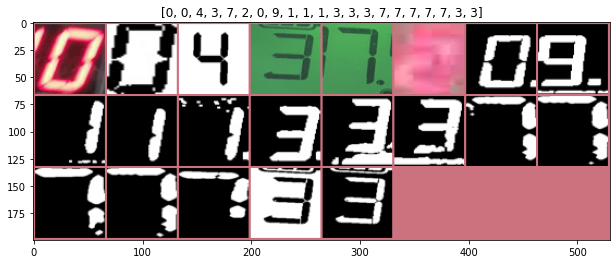

In [12]:
inputs, classes = next(iter(valid_loader))
#inputs, classes = next(iter(valid_loader))
out = torchvision.utils.make_grid(inputs[:32])

imshow(out, title=[i.item() for i in classes[:32]])
plt.show()

In [13]:
valid_acc, predicted = valid(new_model, valid_loader, is_cuda)
#valid_acc = valid(model, valid_loader, is_cuda)
print(predicted, valid_acc)




NameError: name 'new_model' is not defined

In [14]:
pp = predict_model(new_model, test_d)
pp

NameError: name 'new_model' is not defined

In [23]:
error_imgs = []
error_classes = []

for imgs, targets in valid_loader:
    if is_cuda:
        imgs, targets = imgs.cuda(), targets.cuda()
    with torch.no_grad():
        _, pred = torch.max(model(imgs), 1)
        
    for idx, (p,t) in enumerate(zip(pred, targets)):
        if not p==t:
            error_imgs.append(imgs[idx])
            error_classes.append(t)
            
out = torchvision.utils.make_grid(torch.stack(error_imgs, 0))
plt.figure(figsize = (10, 6))

imshow(out.cpu(), title = [i.item() for i in error_classes])

NameError: name 'is_cuda' is not defined

In [ ]:
"/home/ljh/Desktop/OCR_seven_ocr/dataset/digit_data/0/00012_3.jpg"